In [100]:
import pandas_datareader.data as web
import datetime
#from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import requests
import pandas as pd 
import io
import numpy as np
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex

In [121]:
figsize = (12,5)
fontsize = 10

## Import google trends data and Michigan data 

In [122]:
## google search 
ue_search = pd.read_excel('../Data/UEGoogle.xls')
ue_search.index = ue_search['Month']

ue_search.index = pd.DatetimeIndex(pd.to_datetime(ue_search.index,
                                                  format = '%Y-%m'),
                                  freq='infer')
ue_search.index.name = None

ue_search = ue_search.rename(columns = {'unemployment insurance: (United States)':'Search: \"unemployment insurance\"',
                             'unemployment office: (United States)':'Search: \"unemployment office\"',
                             'file for unemployment: (United States)':'Search: \"file for unemployment\"',
                             'unemployment: (United States)':'Search: \"unemployment\"'          })

In [123]:
searches = ['Search: \"unemployment insurance\"',
            'Search: \"unemployment\"',
            'Search: \"unemployment office\"',
            'Search: \"file for unemployment\"']

##########################################################
sub_searches = searches[0:2]
#########################################################

ue_search = ue_search[sub_searches]

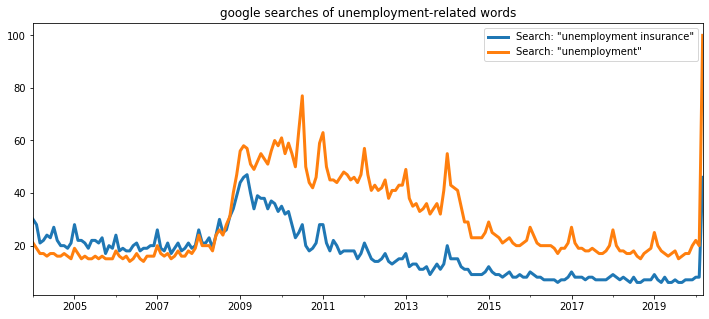

In [124]:
ue_search.plot(lw = 3,
               figsize = figsize,
               title = 'google searches of unemployment-related words')
plt.savefig('figures/search')

In [125]:
## normalize each indicies by its initial value. 

for search in sub_searches:
    ue_search[search] = ue_search[search]*100/ue_search[search][0]

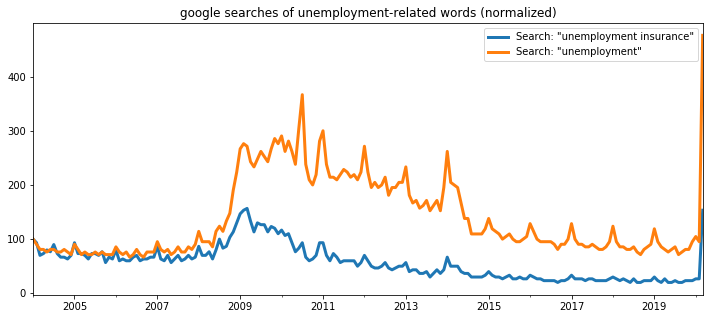

In [126]:
## after normalization
ue_search.plot(lw = 3,
               figsize = figsize,
               title = 'google searches of unemployment-related words (normalized)')
plt.savefig('figures/search_normalized')

In [127]:
## michigan data 
ue_exp = pd.read_excel('../Data/UEExpMichigan.xls',
                       sheet_name = 'Data',
                       index_col = 0)

ue_exp = ue_exp.loc[ue_exp.index.dropna(how='all')]

ue_exp.index = pd.DatetimeIndex(pd.to_datetime(ue_exp.index,
                                               format = '%Y-%m-%d'),
                                  freq = 'infer')
ue_exp.index.name = None

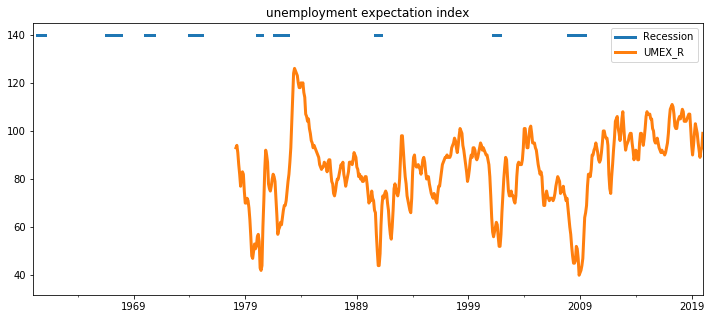

In [128]:
ue_exp.plot(lw = 3,
            figsize = figsize,
           title = 'unemployment expectation index')
plt.savefig('figures/ue_exp_idx')

In [129]:
ue_exp.tail()

,Recession,UMEX_R
2019-09-01,NaN,92.0
2019-10-01,NaN,89.0
2019-11-01,NaN,92.0
2019-12-01,NaN,93.0
2020-01-01,NaN,99.0


## Unemployement rate

In [130]:
start = datetime.datetime(1960, 1, 30)
end = datetime.datetime(2020, 3, 30)
ue = web.DataReader('UNRATE', 'fred', start, end)

In [131]:
ue.index = pd.DatetimeIndex(pd.to_datetime(ue.index,
                                           format = '%Y-%m-%d'),
                                  freq = 'infer')
ue.index.name = None

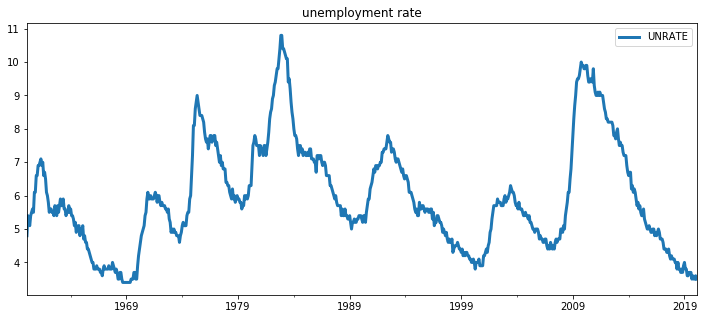

In [132]:
ue.plot(lw = 3,
        figsize = figsize,
        title = 'unemployment rate')
plt.savefig('figures/ue')

## Retail series (excluding vehicles and gas) 

In [133]:
## downloading data from fred 

retail = web.DataReader('MARTSSM44W72USS', 'fred', start, end)
pce_idx = web.DataReader('PCEPI', 'fred', start, end)

retail.index = pd.DatetimeIndex(pd.to_datetime(retail.index,
                                               format = '%Y-%m-%d'),
                                freq = 'MS')

retail = retail.rename(columns={'MARTSSM44W72USS':'retail'})

pce_idx.index = pd.DatetimeIndex(pd.to_datetime(pce_idx.index,
                                               format = '%Y-%m-%d'),
                                freq = 'infer')
retail.index.name = None
pce_idx.index.name = None

## converting from nominal to real  

retail_pce = pd.merge(retail,
                      pce_idx,
                      left_index = True,
                      right_index = True)

In [134]:
retail_pce['deflator'] = retail_pce['PCEPI']/retail_pce['PCEPI'][0]
retail_pce['retail_real'] = retail_pce['retail']/retail_pce['deflator']
retail_pce['lretail_real'] = np.log(retail_pce['retail_real'])
retail_pce['retail_yoy'] = retail_pce['lretail_real'].diff(periods = 12)*100
retail = retail_pce['retail_yoy']

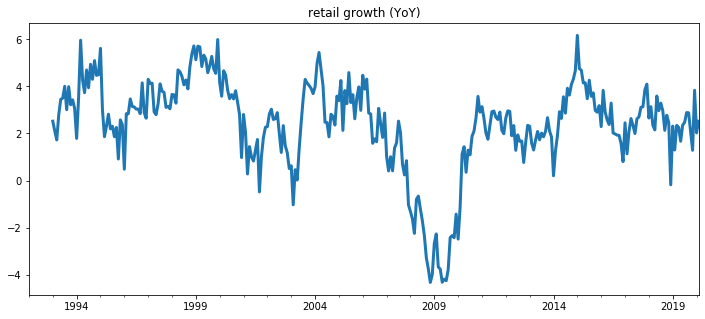

In [135]:
retail.plot(lw = 3,
        figsize = figsize,
        title = 'retail growth (YoY)')
plt.savefig('figures/retail')

## Combine all series 

In [136]:
temp = pd.merge(ue_search,
                ue_exp,
                left_index = True,
                right_index = True,
                how = 'outer'
               )

uedf = pd.merge(temp,
               ue,
               left_index = True,
               right_index = True,
                how = 'outer')

df = pd.merge(uedf,
              retail,
              left_index = True,
              right_index = True,
              how = 'outer')

In [137]:
df = df.rename(columns = {'UNRATE':'ue',
                          'UMEX_R':'ue_exp_idx'})

In [138]:
df.columns

Index(['Search: "unemployment insurance"', 'Search: "unemployment"',
       'Recession', 'ue_exp_idx', 'ue', 'retail_yoy'],
      dtype='object')

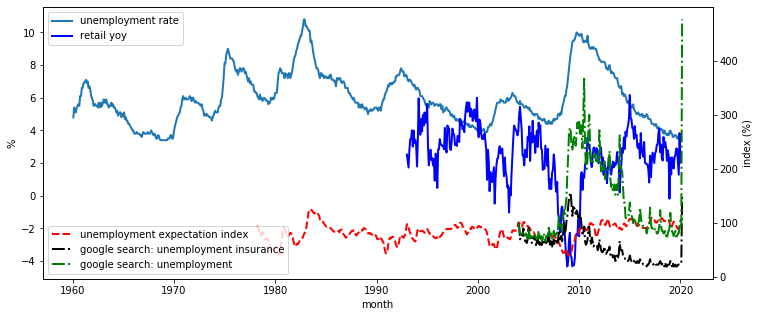

In [145]:
fig, ax = plt.subplots(figsize = figsize)
ax2 = ax.twinx()
ax.plot(df.index,
        df['ue'],
        lw =2, 
        label = 'unemployment rate')

ax.plot(df.index,
        df['retail_yoy'],
        'b-',
        lw =2, 
        label = 'retail yoy')

ax2.plot(df.index,
         df['ue_exp_idx'],'r--',
         lw = 2, 
         label = 'unemployment expectation index')
ax2.plot(df.index,
         df['Search: \"unemployment insurance\"'],
         'k-.',
         lw = 2, 
         label = 'google search: unemployment insurance')
ax2.plot(df.index,
         df['Search: \"unemployment\"'],
         'g-.',
         lw = 2, 
         label = 'google search: unemployment')

#ax2.plot(df.index,df['Search: \"file for unemployment\"'],'g-.',lw = 1, label = 'google search: file for unemployment')
ax.set_xlabel("month",fontsize = fontsize)
ax.set_ylabel('%',fontsize = fontsize)
ax2.set_ylabel('index (%)',fontsize = fontsize)

ax.legend(loc = 0,
          fontsize = fontsize)
ax2.legend(loc = 3,
          fontsize = fontsize)
plt.savefig('figures/all')

## Regression

### Step 1.  predict michigan index using google search  


\begin{eqnarray}
\underbrace{\texttt{UEI}_{t}}_{\text{Unemployment expectation index}} = \alpha + \sum^2_{k=1}\beta_k \texttt{Search}_{k,t} + \epsilon_{t}
\end{eqnarray}

- $\texttt{UEI}$: unemployment expectation index
- $\texttt{Search}_{k,t}$: google search index for query $k$, e.g. "unemployment insurance", "unemployment office", etc. All indicies are normalized by their initial value at the first period of the sample. 

In [146]:
vars_reg = sub_searches + ['ue_exp_idx']

df_short1 = df[vars_reg].dropna(how ='any')

Y = df_short1[['ue_exp_idx']]
X = df_short1[sub_searches]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             ue_exp_idx   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     112.0
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           7.25e-33
Time:                        14:31:12   Log-Likelihood:                -738.92
No. Observations:                 193   AIC:                             1484.
Df Residuals:                     190   BIC:                             1494.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [141]:
print('Coefficients of interest:')
coefs1 = results.params
print(coefs1)

Coefficients of interest:
const                               103.707630
Search: "unemployment insurance"     -0.458891
Search: "unemployment"                0.077344
dtype: float64


In [142]:
def predict_ue_exp(searches,
                   coefs):
    predict_values = coefs[0] + (coefs[1]*searches.T[0]  # important to transform the matrix
                                 + coefs[2]*searches.T[1]
                                 # + coefs1[3]*uedf[searches[2]]
                                )
    return predict_values

In [143]:
ue_exp_idx_prd  = predict_ue_exp(np.array(df[sub_searches].dropna(how='any')),
                          coefs1)

## need to give the right time index again. 

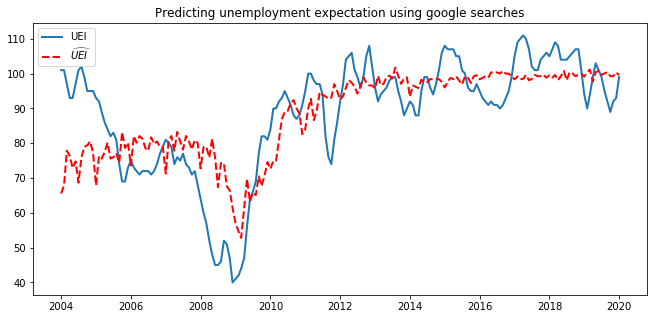

In [59]:
fig = plt.figure(figsize = figsize)
plt.plot(uedf_short1.index,
         uedf_short1['ue_exp_idx'], lw = 2, label = 'UEI')
plt.plot(uedf_short1.index,
         results.predict(),'r--',lw = 2,label=r'$\widehat{UEI}$')
plt.title('Predicting unemployment expectation using google searches')
plt.legend(loc = 2)
plt.savefig('figures/ue_exp_idx_predict')
# Make this an out of sample plot (for the predicted)

In [22]:
uedf.columns

Index(['Search: "unemployment insurance"', 'Search: "unemployment office"',
       'Recession', 'ue_exp_idx', 'ue'],
      dtype='object')

### Step 2.  predict future realized unemployment rate change using expectations 

\begin{eqnarray}
\texttt{U}_{t+h} - \texttt{U}_{t} & = & a_{0}+ a_{1}\widehat{\texttt{UEI}}_{t} + \eta_{t}
\end{eqnarray}

- $\texttt{U}_{t+h}$: h-month-ahead realized unemployment rate, h = 12 by default. change h to predict for different horizons 
- $\widehat{\texttt{UEI}}_{t}$: predicted unemployment rate expectation index at time $t$ 

\begin{eqnarray}
\widehat{\texttt{U}}_{t+h} &= & \hat{a}_{0}+ \hat{a}_{1}\widehat{\texttt{UEI}}_{t} + \texttt{U}_{t} 
\end{eqnarray}


In [23]:
uedf['ue_chg'] = uedf['ue'].diff(periods = 1) ## monthly change of unemployment rate 
uedf_short2 = uedf[['ue_chg','ue_exp_idx']].dropna(how ='any')

## # of months lag 
############################################################
h = 1  #by default, next month unemployment rate 
#############################################################

Y = np.array(uedf_short2['ue_chg'][h:])
X = np.array(uedf_short2['ue_exp_idx'][:-h])
X = sm.add_constant(X)
model2 = sm.OLS(Y,X)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     110.1
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           1.23e-23
Time:                        10:38:26   Log-Likelihood:                 245.83
No. Observations:                 560   AIC:                            -487.7
Df Residuals:                     558   BIC:                            -479.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3389      0.033     10.143      0.0

In [24]:
coefs2 = results2.params
print('Estimated coefficients are')
coefs2

Estimated coefficients are


array([ 0.33889268, -0.00406059])

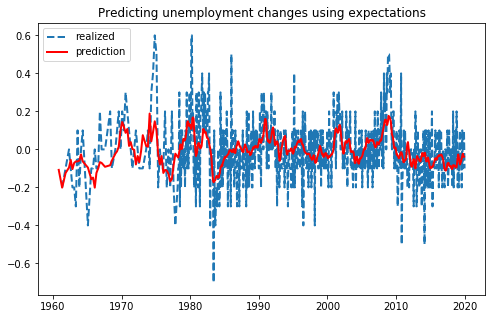

In [25]:
fig = plt.figure(figsize = figsize)
plt.plot(uedf_short2.index[h:],
         np.array(uedf_short2['ue_chg'][h:]), 
         '--',
         lw = 2, 
         label = 'realized')
plt.plot(uedf_short2.index[:-h],
         results2.predict(),
         'r-',
         lw = 2,
         label='prediction')
plt.title('Predicting unemployment changes using expectations')
plt.legend(loc = 2)
plt.savefig('figures/ue_change_predict')

In [26]:
## 2-step procedure to predict the unemployment rate change in March 2020 and onward

In [27]:
searches = ['Search: \"unemployment insurance\"',
            'Search: \"unemployment office\"',
            'Search: \"file for unemployment\"']

## predict unemployment exp index 
ue_exp_idx_predicted = coefs1[0] + (coefs1[1]*uedf[searches[0]]
                                   + coefs1[2]*uedf[searches[1]]
                                  # + coefs1[3]*uedf[searches[2]]
                                  )

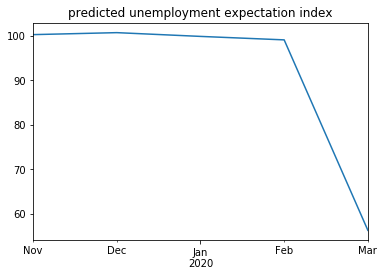

In [28]:
ue_exp_idx_predicted.tail().plot(title = 'predicted unemployment expectation index')
plt.savefig('figures/ue_exp_idx_predict_recent')

In [29]:
## predict unemployment changes 
ue_ch_predicted = coefs2[0] + coefs2[1]*ue_exp_idx_predicted

In [30]:
## change in unemployment rate 

ue_ch_predicted.tail()

2019-11-01   -0.068337
2019-12-01   -0.070147
2020-01-01   -0.066720
2020-02-01   -0.063552
2020-03-01    0.110125
Freq: MS, dtype: float64

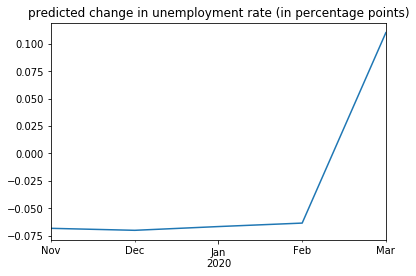

In [31]:
ue_ch_predicted.tail().plot(title = 'predicted change in unemployment rate (in percentage points)')
plt.savefig('figures/ue_change_predict_recent')


\begin{eqnarray}
\newcommand{\Retail}{\texttt{log RS}}
\Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} \hat{U}_{t+12} & \text{Over history to 2019-JAN}
\\ \Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} \texttt{UEI}_{t} & \text{Over history to 2019-JAN}
\\ \Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} \widehat{\texttt{UEI}}_{t}  &\text{Using measured UEI data through its end, then forecasted UEI for last couple of months}
\end{eqnarray}

In [ ]:
# You want Retail Sales Ex motor vehicles
# And you need to get the level of the PCE deflator to turn it into something like a "real" index

https://www.census.gov/retail/marts/www/adv44w72.txt